# <center> $$Catboost\ hyperparameters\ tuning$$

## 1. Installing libraries


In [ ]:
!pip install -Ur ../requirements.txt

In [7]:
import yaml
import shap
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostRegressor, Pool
from optuna import create_study, pruners
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import sys
sys.path.append('.../')
from preprocessing import clean_data, get_data, add_features
# from config import import_config

In [8]:
print(sys.path)

['C:\\Users\\username33\\AppData\\Local\\Programs\\Python\\Python38\\python38.zip', 'C:\\Users\\username33\\AppData\\Local\\Programs\\Python\\Python38\\DLLs', 'C:\\Users\\username33\\AppData\\Local\\Programs\\Python\\Python38\\lib', 'C:\\Users\\username33\\AppData\\Local\\Programs\\Python\\Python38', 'c:\\Users\\username33\\vs_code_projects\\pet_ml_nyc_taxi\\.venv', '', 'c:\\Users\\username33\\vs_code_projects\\pet_ml_nyc_taxi\\.venv\\lib\\site-packages', 'c:\\Users\\username33\\vs_code_projects\\pet_ml_nyc_taxi\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\username33\\vs_code_projects\\pet_ml_nyc_taxi\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\username33\\vs_code_projects\\pet_ml_nyc_taxi\\.venv\\lib\\site-packages\\Pythonwin', '../', '.../', './', '.../', '.../']


In [31]:
cfg={
     'data_split':
          {
           'test_size': 0.2,
           'test_split_seed': 64,
           'valid_size': 0.2,
           'valid_split_seed': 22,
          },
      'catboost':{}
     }

# 2. Data Preprocessing

In [32]:
# config
# cfg = import_config('../config/params.yaml')
test_size = cfg['data_split']['test_size']
test_split_seed = cfg['data_split']['test_split_seed']
valid_size = cfg['data_split']['valid_size']
valid_split_seed = cfg['data_split']['valid_split_seed']

In [23]:
# data preprocessing
path = 'https://media.githubusercontent.com/media/hshsdrop/df_for_downloads/refs/heads/main/train.csv'
df = add_features(clean_data(get_data(path)), path_kmeans='../models/kmeans.pkl', purpose='tuning')
# df = df.sample(frac=0.1, random_state=42)
# df.reset_index(drop=True, inplace=True)
df.shape

(567504, 13)

In [33]:
# processing for tuning & testing
X = df.drop('trip_duration', axis=1)
y = df.trip_duration

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_split_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valid_size, random_state=valid_split_seed)

print(f'train shape == {X_train.shape}')
print(f'validation shape == {X_val.shape}')
print(f'test shape == {X_test.shape}')
cat_feature_indices = ['passenger_count', 'pickup_month', 'pickup_weekday', 'pickup_hour', 'high_traffic', 'anomaly', 'route']
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

train shape == (363202, 12)
validation shape == (90801, 12)
test shape == (113501, 12)


# 3. Catboost tuning

## 3.1 Best Params Searching

In [34]:
params_defolt = {
                'iterations': 1500,
                'boosting_type': 'Plain',
                'bootstrap_type': 'Bernoulli',
                'use_best_model': True,
                'verbose': False,
                'task_type': 'CPU',
                'random_state': 20
                }

In [56]:
def objective(trial):
    params_search = {
        "learning_rate": trial.suggest_uniform("learning_rate", 2e-1, 5e-1), 
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 2e0, 6e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0), 
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "max_bin": trial.suggest_int("max_bin", 700, 1200),
        "depth": trial.suggest_int("depth", 13, 15),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 5, 15)
        }

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    model = CatBoostRegressor(**params_defolt, **params_search)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30, callbacks=[pruning_callback])
    
    # запускаем процесс прунинга
    pruning_callback.check_pruned()
    print(f"N trees = {model.tree_count_}")
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    return score

In [ ]:
# %%time
study = create_study(sampler=TPESampler(),
                     pruner=pruners.MedianPruner(n_warmup_steps=5),
                     direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

In [49]:
# save number i study
i=10

with open(f'../models/studies/study{i}.pkl', 'wb') as f:
    pickle.dump(study, f)

In [9]:
# load number i study
i=9

with open(f'../models/studies/study{i}.pkl', 'rb') as f:
    loaded_study = pickle.load(f)

In [10]:
# Импорт для построения графиков важности гиперпараметров и истории обучения
from optuna import visualization
import nbformat

In [11]:
# История изменения от числа испытаний
visualization.plot_optimization_history(loaded_study)

In [12]:
# Зависимость в разрере по параметрам
visualization.plot_slice(loaded_study)

In [13]:
# Важность параметров
visualization.plot_param_importances(loaded_study)

In [16]:
# Best Params
print("Number of completed trials: {}".format(len(loaded_study.trials)))
print("Best trial:")
trial = loaded_study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 50
Best trial:
	Best Score: 0.3558918142511518
	Best Params: 
    learning_rate: 0.31836840775317227
    l2_leaf_reg: 5.850034036727785
    colsample_bylevel: 0.9576299713874448
    subsample: 0.7838320694358547
    max_bin: 922
    depth: 13
    max_ctr_complexity: 6


In [39]:
# updating params
for key, value in trial.params.items():
    params_defolt[key] = value

## 3.2 Finding N Estimators

In [40]:
params_defolt['iterations'] = 2500

In [42]:
catboost_final = CatBoostRegressor(**params_defolt)
catboost_final.fit(train_pool, eval_set=val_pool,early_stopping_rounds=30, verbose=300)
n_estimators = catboost_final.tree_count_

0:	learn: 0.5731019	test: 0.5721412	best: 0.5721412 (0)	total: 2.29s	remaining: 1h 35m 14s
300:	learn: 0.2659422	test: 0.3543103	best: 0.3542331 (296)	total: 9m 31s	remaining: 1h 9m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3540087908
bestIteration = 324

Shrink model to first 325 iterations.


In [43]:
print(f'Best number of trees = {n_estimators}')

Best number of trees = 325


In [44]:
params_defolt['iterations'] = n_estimators
params_defolt['use_best_model'] = False
best_params = params_defolt

In [45]:
best_params

{'iterations': 325,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'use_best_model': False,
 'verbose': False,
 'task_type': 'CPU',
 'random_state': 20,
 'learning_rate': 0.31836840775317227,
 'l2_leaf_reg': 5.850034036727785,
 'colsample_bylevel': 0.9576299713874448,
 'subsample': 0.7838320694358547,
 'max_bin': 922,
 'depth': 13,
 'max_ctr_complexity': 6}

## 4. Model Quality Estimation

In [46]:
X_train_last = pd.concat([X_train, X_val])
y_train_last = pd.concat([y_train, y_val])
train_pool_last = Pool(X_train_last, y_train_last, cat_features=cat_feature_indices)

In [47]:
best_catboost = CatBoostRegressor(**best_params)
best_catboost.fit(train_pool_last)

In [48]:
y_test_predict = best_catboost.predict(X_test)
y_train_predict = best_catboost.predict(X_train)

In [49]:
from sklearn.metrics import mean_absolute_error

In [50]:
msle_train = np.round(mean_squared_error(y_train, y_train_predict), 2)
msle_test = np.round(mean_squared_error(y_test, y_test_predict), 2)

mae_minutes_train = np.round(mean_absolute_error(np.exp(y_train)/60, np.exp(y_train_predict)/60), 2)
mae_minutes_test = np.round(mean_absolute_error(np.exp(y_test)/60, np.exp(y_test_predict)/60), 2)

r2_train = np.round(r2_score(y_train, y_train_predict), 2)
r2_test = np.round(r2_score(y_test, y_test_predict), 2)

In [51]:
print(f'MSLE Train = {msle_train}')
print(f'MSLE Test = {msle_test}', '\n')
print(f'MAE in Minutes Train = {mae_minutes_train}')
print(f'MAE in Minutes Test = {mae_minutes_test}', '\n')
print(f'r2 Train = {r2_train}')
print(f'r2 Test = {r2_test}')

MSLE Train = 0.08
MSLE Test = 0.13 

MAE in Minutes Train = 2.36
MAE in Minutes Test = 2.48 

r2 Train = 0.83
r2 Test = 0.74


# 5. Feature Importance


## 5.1 Overall 
For each feature shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed. Feature importance values are normalized so that the sum of importances of all features is equal to 100

In [52]:
best_catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,manh_length,25.936284
1,dropoff_latitude,12.349556
2,pickup_hour,11.331275
3,pickup_weekday,9.134496
4,pickup_longitude,7.921411
5,dropoff_longitude,7.909201
6,pickup_latitude,7.283858
7,high_traffic,6.908683
8,route,6.209455
9,pickup_month,4.888147


## 5.2 SHAP values
A vector with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).

In [20]:
vals = np.random.randint(0, X.shape[0], size=1500)
explainer = shap.TreeExplainer(best_catboost)
shap_values = explainer.shap_values(Pool(X.iloc[vals, :], y[vals], cat_features=cat_feature_indices))

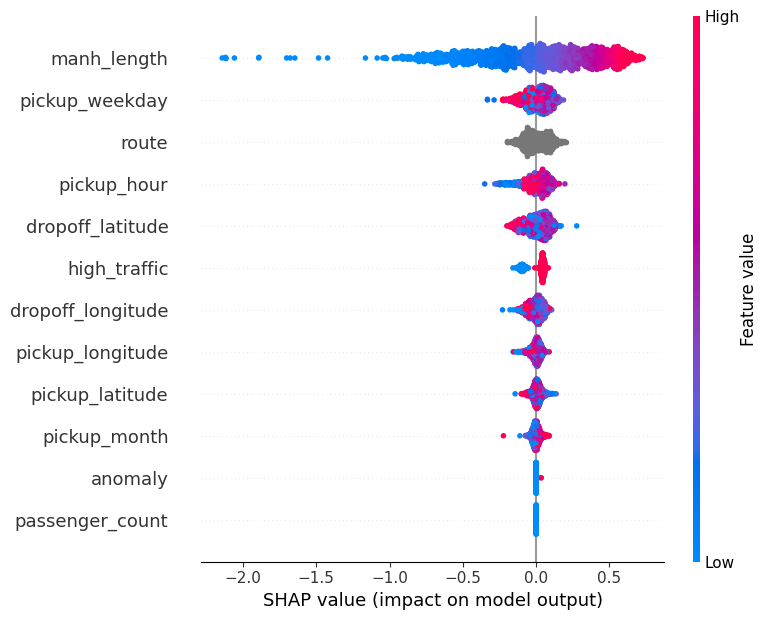

In [23]:
shap.summary_plot(shap_values, X.iloc[vals, :],)

## 6. Saving Params

In [1]:
# best_params['task_type'] = 'CPU'

In [106]:
with open('../config/params.yaml', 'w') as config:
    cfg['catboost'] = best_params
    yaml.safe_dump(cfg, config, default_flow_style=False)

In [115]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../config/params.yaml
	modified:   2_tuning.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [116]:
!git add ../config/params.yaml
!git add 2_tuning.ipynb

In [117]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   ../config/params.yaml
	modified:   2_tuning.ipynb



In [119]:
!git commit -m "add tuning v.2"

[main 3024bbd] add tuning v.3
 2 files changed, 13 insertions(+), 18 deletions(-)


In [120]:
!git push

Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects:  16% (1/6)   
Compressing objects:  33% (2/6)   
Compressing objects:  50% (3/6)   
Compressing objects:  66% (4/6)   
Compressing objects:  83% (5/6)   
Compressing objects: 100% (6/6)   
Compressing objects: 100% (6/6), done.
Writing objects:  14% (1/7)   
Writing objects:  28% (2/7)   
Writing objects:  42% (3/7)   
Writing objects:  57% (4/7)   
Writing objects:  71% (5/7)   
Writing objects:  85% (6/7)   
Writing objects: 100% (7/7)   
Writing objects: 100% (7/7), 987 bytes | 493.00 KiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/EuMentality//nyc_taxi_trip_proj
   72c3475..3024bbd  main -> main
